In [181]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier
from tqdm import tqdm
from time import time
import resource

data = pd.read_excel("~/projects/Sano/sanoproject_ENO.xlsx",sheet_name="fukuoka", index_col="ID")
data = data[data.target != 3]
data["maligvsbenign"] = [1 if x<3 else 0 for x in data.target]
data["Sex"] = [1 if x == "F" else 0 for x in data.Sex]
X = data[['intbronch','plasmacellinfil', 'eosinoinfil', 'lymphoidagg', 'fibroelastosis', 'op',]]
X = X.rename(columns={'intbronch':"IB/B",
                       'plasmacellinfil':"PLC",
                       'eosinoinfil':"Eo",
                       'lymphoidagg':"Ly",
                       'fibroelastosis':"FE",
                       'op':"OP",
                       })
y = data["maligvsbenign"]




X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=data["target"], random_state=184)

100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


<Axes: xlabel='Accuracy', ylabel='AUC'>

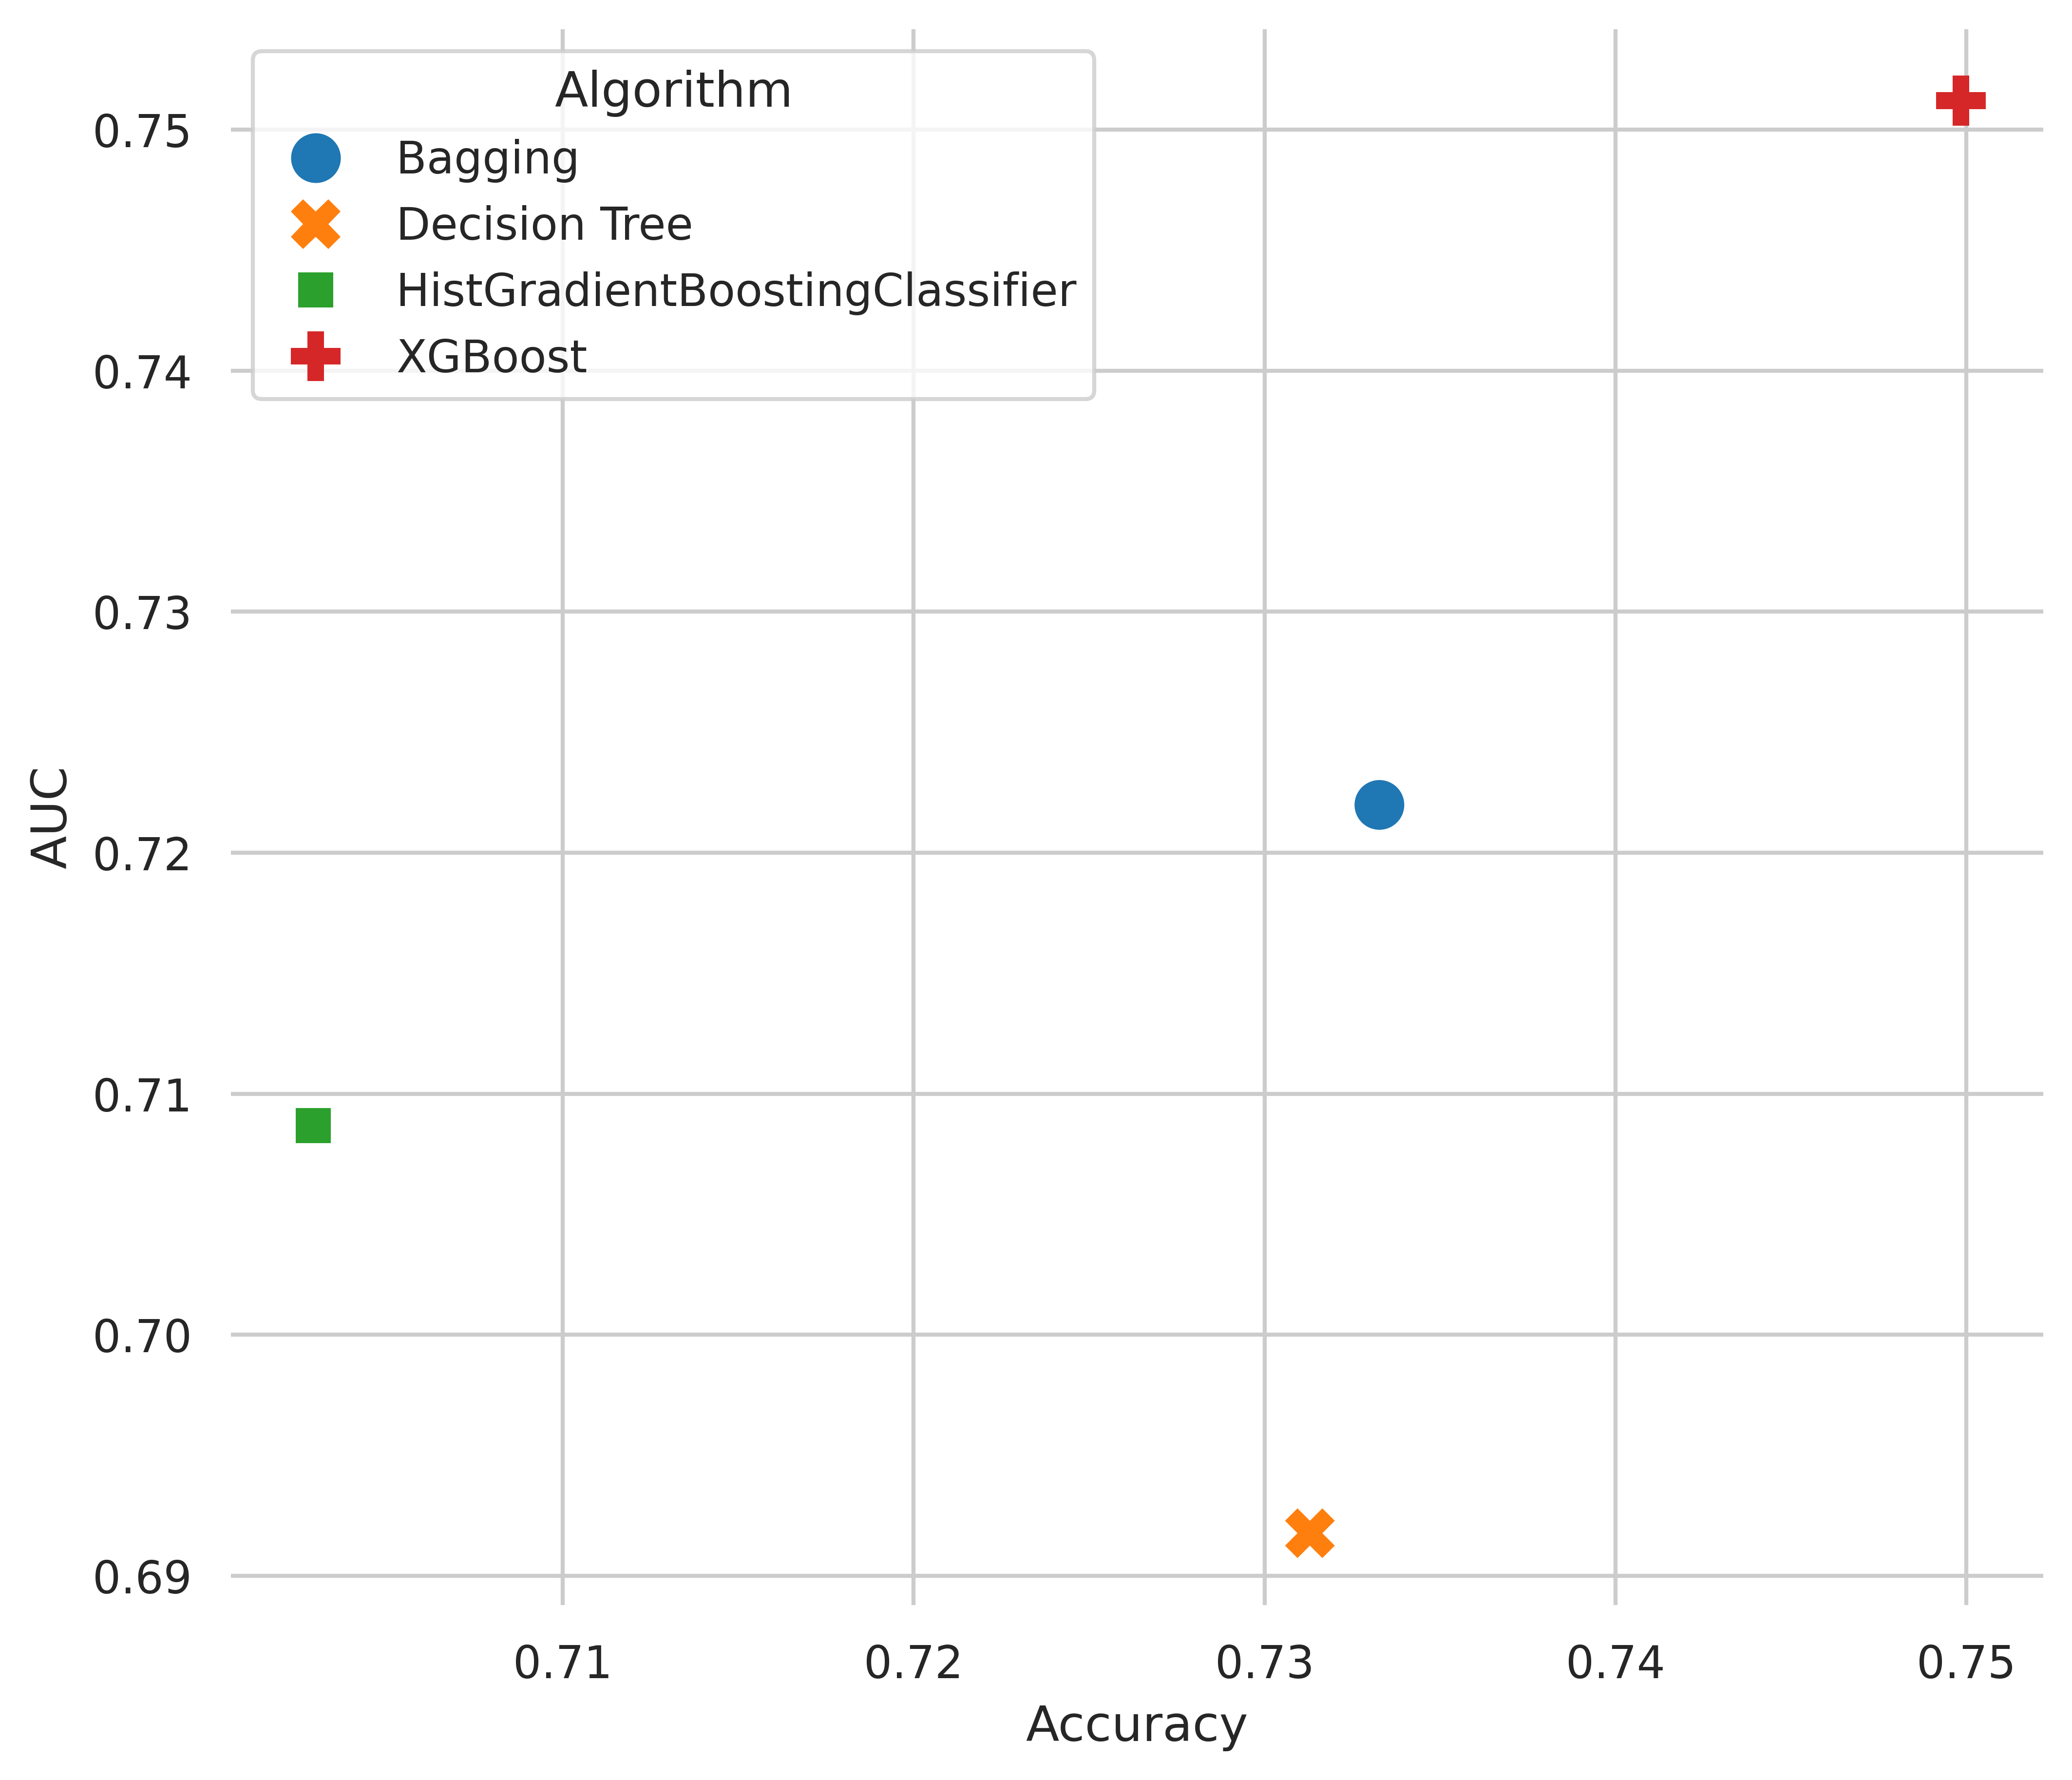

In [183]:

names = [
    "Decision Tree",
    "XGBoost",
    "HistGradientBoostingClassifier",
    "Bagging",
]

scores=[]

for i in tqdm(range(1000)):
	X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=data["target"])
	classifiers = [
	    DecisionTreeClassifier(),
        xgb.XGBClassifier(reg_alpha = 1),
        HistGradientBoostingClassifier(),
        BaggingClassifier(),
	]
	for name, clf in zip(names, classifiers):
		start = time()
		clf.fit(X_train, y_train)
		preds = clf.predict(X_test)
		score = clf.score(X_test, y_test)
		proba = clf.predict_proba(X_test)[:,1]
		auc = roc_auc_score(y_test, proba)
		f1 = f1_score(y_test, preds)
		precision = precision_score(y_test, preds)
		recall = recall_score(y_test, preds)
		end = time()
		extime = end-start
		output= [name, score, auc, f1, precision, recall, extime]
		scores.append(output)
		# ConfusionMatrixDisplay.from_predictions(y_test, preds).ax_.set_title(name)
		# plt.grid(False)
		# plt.savefig(fname = f"{name}_cm.jpeg", dpi = 1000)
		
scores = pd.DataFrame(scores)


# plot
accuracy = [scores[1][i] for i in range(len(scores))]

auc = [scores[2][i] for i in range(len(scores))]
namesplot = [scores[0][i] for i in range(len(scores))]

plotdf = pd.DataFrame([accuracy,auc,namesplot]).T
plotdf = plotdf.rename(columns={0:"Accuracy",1:"AUC",2:"Algorithm"})

medians = plotdf.groupby("Algorithm")[["Accuracy","AUC"]].median()
means = plotdf.groupby("Algorithm")[["Accuracy","AUC"]].mean()


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(8,7))
fig.set_dpi(600)
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(x="Accuracy", y="AUC",
                hue="Algorithm",
                palette="tab10",
				style="Algorithm",
                linewidth=0, s=150,
                data=means, ax=ax, edgecolors="grey")

In [184]:
scores

,0,1,2,3,4,5,6
0,Decision Tree,0.686275,0.655428,0.783784,0.690476,0.90625,0.014555
1,XGBoost,0.803922,0.837171,0.864865,0.761905,1.00000,0.221280
2,HistGradientBoostingClassifier,0.745098,0.759046,0.811594,0.756757,0.87500,0.067147
3,Bagging,0.745098,0.847039,0.821918,0.731707,0.93750,0.027203
4,Decision Tree,0.764706,0.726151,0.833333,0.750000,0.93750,0.010464
...,...,...,...,...,...,...,...
3995,Bagging,0.803922,0.794408,0.864865,0.761905,1.00000,0.028544
3996,Decision Tree,0.803922,0.794408,0.857143,0.789474,0.93750,0.013091
3997,XGBoost,0.784314,0.769737,0.845070,0.769231,0.93750,0.110996
3998,HistGradientBoostingClassifier,0.705882,0.766447,0.782609,0.729730,0.84375,0.071012
